# Project 3: Proton Emission: Mackenzie Smith

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Following is useful information for the model:


Using Fermi's Golden rule, we can calculate a rate of transition for the proton decay in a proton-emitting nucleus. First, we'll define the potential that defines our system, where a core nucleus and an unpaired proton interact via the following:
$$ V(r) = V_{WS} + V_{Coul} + \frac{\hbar ^2}{2 \mu r^2} l (l + 1) $$,
where
$$ V_{WS} = -V_0 f_{WS}(r) + V_{SO} \Biggl ( \frac{\hbar}{m_{\pi}c}  \Biggr )^2 \frac{2}{r} \Biggl [ \frac{d}{dr} f_{WS}(r) \Biggr ] (\vec{l} \cdot \vec{s} ) $$
$$ f_{WS}(r) = 
\frac{1}{1 + exp[(r-R)/a]} \qquad \text{Woods-Saxon form factor} $$
$$ V_{Coul}(r) = \left\{
    \begin{array}{lr}
         \frac{Ze^2}{r} & \text{for } r > R\\
         \frac{Ze^2}{2R}\biggl [ 3 - \biggl ( \frac{r}{R} \biggr ) ^2 \biggr ] & \text{for } r \leq R
    \end{array}
\right\} $$
Taking: $$e^2 = 1.4399764 \text{ MeV fm}, \quad a = 0.7 \text{ fm}, \quad \biggl ( \frac{\hbar}{m_{pi}c} \biggr ) ^2 \approx 2.044 \text{ fm}^2 $$
And assuming: $$  V_0 = 54 \text{ MeV} \quad R = 1.2A^{1/3} \text{ fm}, \quad V_{SO} = 0.2V_0  $$

Using this information, we can calculate the rate of decay through the following expression:

$$ \Gamma = S_p \mathcal{N} \frac{\hbar^2}{4 \mu} exp \biggl \{ -2 \int_{r_1}^{r_2} |k(r)| dr \biggr \} \quad T_{1/2} = \hbar \text{ ln } 2/\Gamma $$

where, $$  \hbar k (r) = \sqrt{2 \mu [E_0 - V_{(r)} ]} \quad \frac{1}{\mathcal{N}} = \frac{1}{2} \int_{r_0} ^{r_1}  \frac{dr}{k(r)} $$ and $S_p$ is the proton spectroscopic factor.

### 1.) Assuming $S_p =1$ compute partial decay half-lives for proton emission for the following cases:

Below, I have extracted a table of proton emitters from the publication Phys. Rev. C 56, 1762 (1997). Here, I have labelled "Z" and "A" as the atomic number and mass number of the daughter nucleus, respectively. "Q" is the Q-value of the proton emission reaction, the "l" and "j" are quantum numbers of the odd proton single particle state before decay, and the "Texpt" is the experimentally derived partial decay rate through this proton emission channel.

In [11]:
## universal constants
e2 = 1.4399764 # MeV*fm
a = 0.7 # fm
hbarmpic = 2.044 #fm^2 (hbar/m_pi c)^2
V0 = 54 # MeV
## R = 1.2A^1/3
Vso = 0.2*V0
Num = 200000 # number for the number of steps in an integration calculation

df = pd.read_csv("sphericalprotonemitters_ver2-Copy1.csv")
df.at[4,'dTup'] = 10
print(df)

    Z    A      Q  l    j     Texpt    dTdown       dTup initNucleus
0  52  108  0.829  2  2.5  0.000109  0.000017   0.000017        109I
1  54  112  0.977  4  3.5  0.000033  0.000007   0.000007       113Cs
2  68  146  1.071  5  5.5  2.700000  0.900000   2.400000       147Tm
3  68  146  1.139  2  1.5  0.000360  0.000080   0.000080      147Tm*
4  70  149  1.285  5  5.5  0.010000  0.000000  10.000000       150Lu
5  70  150  1.255  5  5.5  0.120000  0.040000   0.120000       151Lu
6  72  155  1.015  2  1.5  0.165000  0.055000   0.165000       156Ta
7  74  159  1.250  2  1.5  0.000870  0.000170   0.000230       160Re


In [120]:
#print(df.iloc[0].values)

In [89]:
## functions

def WoodsSaxonFunc(r,R):
    return 1./(1+np.exp((r-R)/a))

def WoodsSaxonPotential(r,R,l,j):
    dr = 0.000001*r
    ddrFws = (WoodsSaxonFunc(r+dr,R)-WoodsSaxonFunc(r-dr,R))/(2*dr)
    s = j-l
    ls = (1/2)*(j*(j+1)-l*(l+1)-s*(s+1))
    return -V0*WoodsSaxonFunc(r,R)+Vso*hbarmpic*(2/r)*ddrFws*(ls)
#print(WoodsSaxonPotential(2.5,5.7,2,2.5))

def Vcoul(r,R,Z):
    if r > R:
        return Z*e2/r
    else:
        return Z*e2/(2*R)*(3-(r/R)**2)

def Vtot(r,R,Z,l,j):
    return WoodsSaxonPotential(r,R,l,j)+Vcoul(r,R,Z)+(1/(2*r**2))*(197.327**2)/(938.272)*l*(l+1)

def k(r,Q,R,Z,l,j):
    return np.sqrt(2*(938.272/(197.327*197.327))*np.abs((Q-Vtot(r,R,Z,l,j))))

def N(r0,r1,Q,R,Z,l,j):
    rspace = np.linspace(r0,r1,Num)
    Nsum = 0
    dr = rspace[1]-rspace[0]
    Nsum = dr/(3*k(rspace[0],Q,R,Z,l,j))
    Nsum += dr/(3*k(rspace[-1],Q,R,Z,l,j))
    for i in range(1,Num-1):
        if i%2 == 1:
            fac = 4
        else:
            fac = 2
        step = (fac/3)*dr/k(rspace[i],Q,R,Z,l,j)
        Nsum += step
    Ninv = (.5)*Nsum
    return 1/Ninv

def Gamma(Sp,r0,r1,r2,Q,R,Z,l,j):
    rspace = np.linspace(r1,r2,Num)
    dr = rspace[1] - rspace[0]
    Nterm = N(r0,r1,Q,R,Z,l,j)
    
    massterm = Sp*197.327*197.327/(4*938.272)
    Nsum = (dr/3)*np.real(k(rspace[0],Q,R,Z,l,j))/2
    Nsum += (dr/3)*np.real(k(rspace[-1],Q,R,Z,l,j))/2
    for i in range(0,Num):
        if i%2 == 1:
            fac = 4
        else:
            fac = 2
        step = (fac*dr/3)*np.real(k(rspace[i],Q,R,Z,l,j))
        Nsum += step
    #print(Nsum)
    return massterm*Nterm*np.exp(-2*Nsum)


In [81]:
def zerofinder(Vtot,R,Z,l,j,guess,E,thresh):
    variable = True
    ro=guess
    while variable:
        if np.abs(Vtot(ro,R,Z,l,j)-E) < thresh:
            variable = False
        else:
            dr = .000001
            ddr = (Vtot(ro+dr,R,Z,l,j)-Vtot(ro-dr,R,Z,l,j))/(2*dr)
            ro = ro-Vtot(ro,R,Z,l,j)/ddr + E/ddr
        #print(Vtot(ro,R,Z,l,j))
    return ro

def CalcHalfLife(Sp,Z,A,Q,l,j):
    R = 1.2*A**(1/3)
    r0 = zerofinder(Vtot,R,Z,l,j,.5,Q,0.0001)
    r1 = zerofinder(Vtot,R,Z,l,j,6.2,Q,0.0001)
    r2 = zerofinder(Vtot,R,Z,l,j,100,Q,0.0001)
#    print(r0)
#    print(r1)
#    print(r2)
    gamma = Gamma(Sp,r0,r1,r2,Q,R,Z,l,j)
    hbar = (6.582*10**(-22))*np.log(2) # MeV s
    return hbar/gamma,r0

#print(CalcHalfLife(1,71,151,1.255,5,5.5))

In [82]:
InitLifetime = np.zeros(len(df))
for i in range(0,len(df)):
    args = df.iloc[i].values
    InitLifetime[i] = CalcHalfLife(1,args[0],args[1],args[2],args[3],args[4])[0]

Using the above table, we can calculate the theoretical half-lives by first assuming the proton spectroscopic factor is uniform and identity for each case. Doing this, I show the results in the plot below, where the experimental value is shown in red with experimental error bars (note, in the case of Lutetium-150, there was only a constraint on the lower value, so the error bars used here extend upwards to infinity) and the theoretical calculations are in blue.

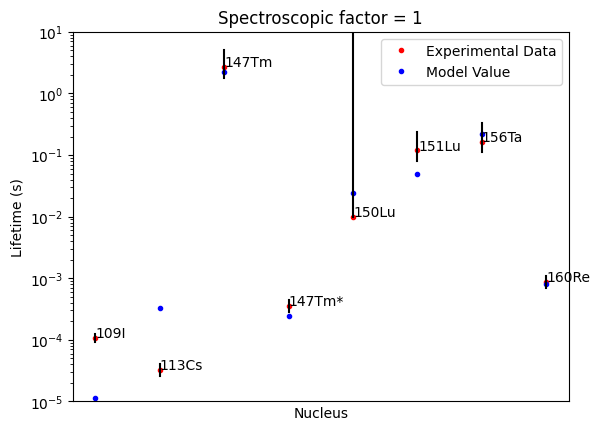

In [83]:
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
for i in range(0,len(df)):
    args = df.iloc[i].values
    if i == 5:
        ax.plot(i,args[-4],'r.',label="Experimental Data" if i == 0 else None)
        ax.text(i+.02,args[-4], args[-1])
        ax.plot(i,InitLifetime[i],'b.',label="Model Value" if i == 0 else None)
        errorx = [i,i]
        errory = [args[-4]-args[-3],args[-4]+args[-2]]
        ax.plot(errorx,errory,'black')
    else:
        ax.plot(i,args[-4],'r.',label="Experimental Data" if i == 0 else None)
        ax.text(i,args[-4], args[-1])
        ax.plot(i,InitLifetime[i],'b.',label="Model Value" if i == 0 else None)
        errorx = [i,i]
        errory = [args[-4]-args[-3],args[-4]+args[-2]]
        ax.plot(errorx,errory,'black')
ax.set_ylim(.00001,10)
ax.set_xlabel("Nucleus")
ax.set_ylabel("Lifetime (s)")
ax.set_title("Spectroscopic factor = 1")
ax.get_xaxis().set_ticks([])
ax.legend()
plt.show()

In text, the calculated lifetimes are shown below:

In [84]:
print("")
for i in range(0,len(df)):
    args = df.iloc[i].values
    print("For the decaying nucleus {}, the proton emission lifetime is {:.3e}".format(args[-1],InitLifetime[i]))
    #print("For Z = {} and A = {}, lifetime is {:.3e}".format(args[0]+1,args[1]+1,InitLifetime[i]))
print("")


For the decaying nucleus 109I, the proton emission lifetime is 1.123e-05
For the decaying nucleus 113Cs, the proton emission lifetime is 3.243e-04
For the decaying nucleus 147Tm, the proton emission lifetime is 2.195e+00
For the decaying nucleus 147Tm*, the proton emission lifetime is 2.456e-04
For the decaying nucleus 150Lu, the proton emission lifetime is 2.410e-02
For the decaying nucleus 151Lu, the proton emission lifetime is 4.861e-02
For the decaying nucleus 156Ta, the proton emission lifetime is 2.204e-01
For the decaying nucleus 160Re, the proton emission lifetime is 8.006e-04



### 2.) For $^{147}$Tm, plot T$_{1/2}$ (in a log$_{10}$ scale) as a function of Q$_p$-value for several values of $l$. Discuss the result.

Here, I begin by using the same structure of code to calculate the lifetimes of proton emission. However, instead of using the Q-values provided by the text (Aberg et al. 1997), I use a range of values between 0.5 MeV and 1.8 MeV. For the reader, I simply stopped at 1.8 MeV because my zero finder algorithm was struggling to work with the larger Q-values as the bounds of integration got closer to each other. In this case, we investigate the 0h$_{11/2}$ and 1d$_{3/2}$ states of $^{147}$Tm, where the former has a larger $l$, hence a larger potential to overcome due to the orbital term in the potential. This can be seen in that its lifetime is orders of magnitude larger, even at higher Q-values, where the rate is higher. The graph is shown below, where we can see that on a logarithmic scale, the theoretical predictions match well with the experimental data.

In [85]:
#InitLifetime = np.zeros(len(df))
#for i in range(0,len(df)):
#    args = df.iloc[i].values
#    InitLifetime[i] = CalcHalfLife(1,args[0],args[1],args[2],args[3],args[4])[0]
   
QvalueSize = 10
Qvals = np.linspace(.5,1.8,QvalueSize)
hstatevals = np.zeros(QvalueSize)
dstatevals = np.zeros(QvalueSize)

hargs = df.iloc[2].values
dargs = df.iloc[3].values

for i in range(0,QvalueSize):
    hstatevals[i] = CalcHalfLife(1,hargs[0],dargs[1],Qvals[i],hargs[3],hargs[4])[0]
    dstatevals[i] = CalcHalfLife(1,dargs[0],dargs[1],Qvals[i],dargs[3],dargs[4])[0]

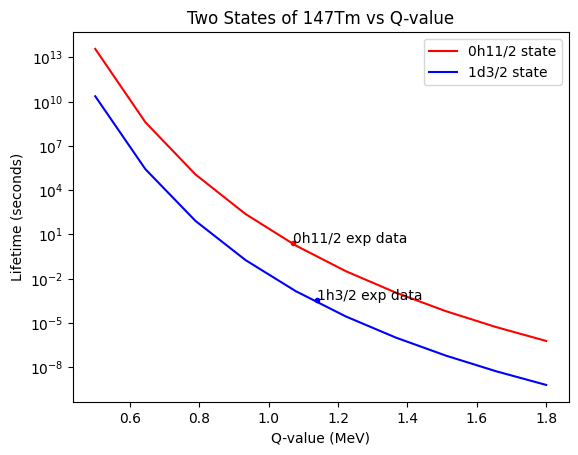

In [86]:
print("")
fig = plt.figure(2)
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
ax.plot(Qvals,hstatevals,'r',label='0h11/2 state')
ax.plot(Qvals,dstatevals,'b',label='1d3/2 state')
ax.plot(hargs[2],hargs[5],'r.')
ax.text(hargs[2],hargs[5],"0h11/2 exp data")
ax.plot(dargs[2],dargs[5],'b.')
ax.text(dargs[2],dargs[5],"1h3/2 exp data")
plt.legend(loc='upper right')
plt.title("Two States of 147Tm vs Q-value")
plt.xlabel("Q-value (MeV)")
plt.ylabel("Lifetime (seconds)")
#ax.set_xlim(.5,1.8)
plt.show()
print("")

In [87]:
#CalcHalfLife(1,hargs[0],dargs[1],Qvals[i],hargs[3],hargs[4])[0]

### 3.) Using computed and experimental half-lives, extract the spectroscopic factors.

As we have already calculated the theoretical lifetimes and have the experimental lifetimes, we can compute the spectroscopic factor as the ratio between the theoretical prediction and the experimental lifetime:
$$ S_p = t_{1/2}^{th}/t_{1/2}^{exp}$$,
as defined in (Aberg, et al. 1997).

In [88]:
#print(df)
#print(InitLifetime)
print("")
for i in range(0,len(df)):
    args = df.iloc[i].values
    print("The proton spectroscopic factor for the decay of {:s} is {:.2f}" .format(args[-1],InitLifetime[i]/args[5]))
print("")


The proton spectroscopic factor for the decay of 109I is 0.10
The proton spectroscopic factor for the decay of 113Cs is 9.83
The proton spectroscopic factor for the decay of 147Tm is 0.81
The proton spectroscopic factor for the decay of 147Tm* is 0.68
The proton spectroscopic factor for the decay of 150Lu is 2.41
The proton spectroscopic factor for the decay of 151Lu is 0.41
The proton spectroscopic factor for the decay of 156Ta is 1.34
The proton spectroscopic factor for the decay of 160Re is 0.92



### 4.) Compute the neutron decay width for a neutron in a h$_{11/2}$ shell in a nucleus with A=150 as a function of E$_0$. Discuss the result.

In this case, the main difference in the defining potential for the interaction is that the Coulomb term disappears since neutrons have net-zero charge. Additionally, the mass of the neutron needs to be considered instead of the proton mass. 

In [115]:
## functions

def WoodsSaxonFunc2(r,R):
    return 1./(1+np.exp((r-R)/a))

def WoodsSaxonPotential2(r,R,l,j):
    dr = 0.000001*r
    ddrFws = (WoodsSaxonFunc2(r+dr,R)-WoodsSaxonFunc2(r-dr,R))/(2*dr)
    s = j-l
    ls = (1/2)*(j*(j+1)-l*(l+1)-s*(s+1))
    return -V0*WoodsSaxonFunc2(r,R)+Vso*hbarmpic*(2/r)*ddrFws*(ls)
#print(WoodsSaxonPotential(2.5,5.7,2,2.5))

def Vcoul2(r,R,Z):
    return 0.
    #if r > R:
    #    return Z*e2/r
    #else:
    #    return Z*e2/(2*R)*(3-(r/R)**2)

def Vtot2(r,R,Z,l,j):
    return WoodsSaxonPotential2(r,R,l,j)+Vcoul2(r,R,Z)+(1/(2*r**2))*(197.327**2)/(939.565)*l*(l+1)

def k2(r,Q,R,Z,l,j):
    return np.sqrt(2*(939.565/(197.327*197.327))*np.abs((Q-Vtot2(r,R,Z,l,j))))

def N2(r0,r1,Q,R,Z,l,j):
    rspace = np.linspace(r0,r1,Num)
    Nsum = 0
    dr = rspace[1]-rspace[0]
    Nsum = dr/(3*k2(rspace[0],Q,R,Z,l,j))
    Nsum += dr/(3*k2(rspace[-1],Q,R,Z,l,j))
    for i in range(1,Num-1):
        if i%2 == 1:
            fac = 4
        else:
            fac = 2
        step = (fac/3)*dr/k2(rspace[i],Q,R,Z,l,j)
        Nsum += step
    Ninv = (.5)*Nsum
    return 1/Ninv

def Gamma2(Sp,r0,r1,r2,Q,R,Z,l,j):
    rspace = np.linspace(r1,r2,Num)
    dr = rspace[1] - rspace[0]
    Nterm = N2(r0,r1,Q,R,Z,l,j)
    
    massterm = Sp*197.327*197.327/(4*939.565)
    Nsum = (dr/3)*np.real(k2(rspace[0],Q,R,Z,l,j))/2
    Nsum += (dr/3)*np.real(k2(rspace[-1],Q,R,Z,l,j))/2
    for i in range(0,Num):
        if i%2 == 1:
            fac = 4
        else:
            fac = 2
        step = (fac*dr/3)*np.real(k2(rspace[i],Q,R,Z,l,j))
        Nsum += step
    #print(Nsum)
    return massterm*Nterm*np.exp(-2*Nsum)

def zerofinder2(Vtot2,R,Z,l,j,guess,E,thresh):
    variable = True
    ro=guess
    while variable:
        if np.abs(Vtot2(ro,R,Z,l,j)-E) < thresh:
            variable = False
        else:
            dr = .000001
            ddr = (Vtot2(ro+dr,R,Z,l,j)-Vtot2(ro-dr,R,Z,l,j))/(2*dr)
            ro = ro-Vtot2(ro,R,Z,l,j)/ddr + E/ddr
        #print(Vtot(ro,R,Z,l,j))
    return ro

def CalcHalfLife2(Sp,Z,A,Q,l,j):
    R = 1.2*A**(1/3)
    r0 = zerofinder2(Vtot2,R,Z,l,j,.5,Q,0.0001)
    r1 = zerofinder2(Vtot2,R,Z,l,j,6.2,Q,0.0001)
    r2 = zerofinder2(Vtot2,R,Z,l,j,12,Q,0.0001)
#    print(r0)
#    print(r1)
#    print(r2)
    gamma = Gamma2(Sp,r0,r1,r2,Q,R,Z,l,j)
    hbar = (6.582*10**(-22))*np.log(2) # MeV s
    return hbar/gamma,r0

#print(CalcHalfLife2(1,0.,149,.25,5,5.5))

In [116]:
QvalueSize = 10
Qvals = np.linspace(.25,2.5,QvalueSize)
Nstatevals = np.zeros(QvalueSize)

for i in range(0,QvalueSize):
    Nstatevals[i] = CalcHalfLife2(1,0,149.,Qvals[i],5,5.5)[0]

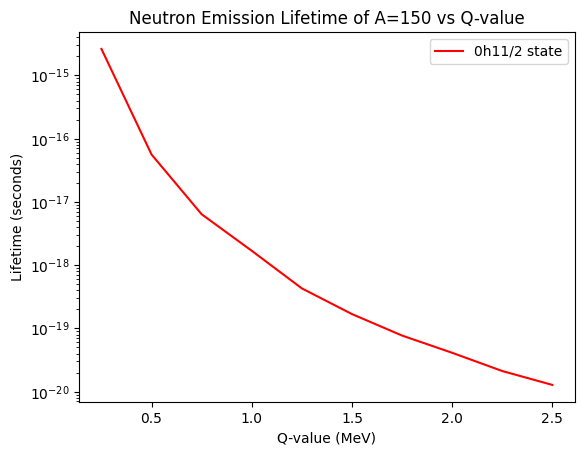

In [114]:
print("")
fig = plt.figure(2)
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
ax.plot(Qvals,Nstatevals,'r',label='0h11/2 state')
#ax.plot(hargs[2],hargs[5],'r.')
#ax.text(hargs[2],hargs[5],"0h11/2 exp data")
#ax.plot(dargs[2],dargs[5],'b.')
#ax.text(dargs[2],dargs[5],"1h3/2 exp data")
plt.legend(loc='upper right')
plt.title("Neutron Emission Lifetime of A=150 vs Q-value")
plt.xlabel("Q-value (MeV)")
plt.ylabel("Lifetime (seconds)")
#ax.set_xlim(.5,1.8)
plt.show()
print("")

As shown above,the transition lifetimes for neutron emission are much lower than for proton emission. This makes sense considering there is no Coulomb potential and the neutron must tunnel through a lower potential. However, there are less spontaneous neutron emitters because the necessary condition of neutron decay leading to a more bound nucleus is rarer and more often than not, it is energetically favorable to beta decay. There are light nuclei such as $^5$He and $^{13}$Be who decay through rapid neutron emission. And these lifetimes are on extremely tiny time scales, matching up with our calculations in the graph above.

In [117]:
# r0 = 3.393
# r1 = 5.613
# r2 = 241.74
R = 1.2*109**(1/3)
#print(k(30.73222,.829,5.73222,53,2,2.5))
#print(Vtot(5.8322,5.7322,53,2,2.5))
#print(R)
#print(Gamma(1,1.87,6.6165,93.66,.829,R,53,2,2.5))
#print(6.582*10**(-22)*np.log(2)/Gamma(1,1.87,6.6165,93.66,.829,R,53,2,2.5))

In [118]:
#rspace = np.linspace(1,250,10000)
#Vtotspace = np.zeros(10000)
#Vcoulspace = np.zeros(10000)
#Vws = np.zeros(10000)
#VSO = np.zeros(10000)
#for i in range(0,10000):
#    R = 1.2*113**(1/3)
#    Vtotspace[i] = Vtot(rspace[i],R,0.,4,3.5)
#    Vcoulspace[i] = Vcoul(rspace[i],R,0.)
#    Vws[i] = WoodsSaxonPotential(rspace[i],R,2,2.5)
#    VSO[i] = Vtotspace[i] - Vcoulspace[i] - Vws[i]
    
#plt.figure(1)
#plt.plot(rspace,Vtotspace)
#plt.plot(rspace,Vcoulspace)
#plt.plot(rspace,Vws,'r')
#plt.plot(rspace,VSO,'b')
#plt.axhline(3,color='black')
#plt.xlim(1,30)
#plt.ylim(0,10)
#plt.show()

In [119]:
#np.sqrt((197*197)/2.044)